## Import Necessary Libraries

In [ ]:
!pip install demoji
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 461.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.2 MB/s eta 0:00:00


In [ ]:
# IMPORT THE NEEDED LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB


import re
import nltk
from collections import Counter
from wordcloud import WordCloud
import itertools
import string
import demoji
demoji.download_codes()
import contractions

# DOWNLOADING NEEDED NLTK RESOURCES
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

<ipython-input-3-894610ed043b>:28: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import pandas as pd
path = '/content/drive/MyDrive/MSc Dissertation'
df_shuffled=pd.read_csv(path + '/df_shuffled.csv')

In [ ]:
null_counts = df_shuffled.isnull().sum()

In [ ]:
df_shuffled = df_shuffled.dropna()

In [ ]:
# Split dataset into features and labels
X = df_shuffled['df_cleaned']
y = df_shuffled['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Load GloVe Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

--2024-09-12 10:04:01--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2024-09-12 10:04:01--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2024-09-12 10:04:01--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

In [ ]:
from tqdm import tqdm
from sklearn.base import BaseEstimator, TransformerMixin

# GloVe 100D

In [ ]:
def load_glove_embeddings(file_path, embedding_dim):
    print(f"Loading GloVe embeddings ({embedding_dim}d)...")
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

    from sklearn.base import BaseEstimator, TransformerMixin

# Load the embeddings (choose one of these)
#glove_50d = load_glove_embeddings('glove.twitter.27B.50d.txt', 50)
glove_100d = load_glove_embeddings('glove.twitter.27B.100d.txt', 100)
#glove_200d = load_glove_embeddings('glove.twitter.27B.200d.txt', 200)

glove_file = '/content/glove.twitter.27B.100d.txt'
embedding_dim = 100
glove_dict = load_glove_embeddings(glove_file, embedding_dim)

class GloVeVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, glove_dict, embedding_dim):
        self.glove_dict = glove_dict
        self.embedding_dim = embedding_dim

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.glove_dict.get(word, np.zeros(self.embedding_dim))
                     for word in text.split()
                     if word in self.glove_dict]
                    or [np.zeros(self.embedding_dim)], axis=0)
            for text in X
        ])


Loading GloVe embeddings (100d)...


Loading GloVe: 6135it [00:00, 14867.97it/s]


Loading GloVe embeddings (100d)...


Loading GloVe: 6135it [00:00, 17005.99it/s]


##LOGISTIC REGRESSION

Cross-validation scores: [0.85215551 0.8583708  0.85861659 0.86099722 0.85755852]
Mean cross-validation accuracy: 0.8575 (+/- 0.0059)
Training Accuracy: 0.8576
Testing Accuracy: 0.8591

Training Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.30      0.41      6284
           1       0.87      0.97      0.92     31523

    accuracy                           0.86     37807
   macro avg       0.77      0.63      0.67     37807
weighted avg       0.84      0.86      0.83     37807


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.28      0.39      1512
           1       0.88      0.97      0.92      7940

    accuracy                           0.86      9452
   macro avg       0.75      0.63      0.66      9452
weighted avg       0.84      0.86      0.84      9452



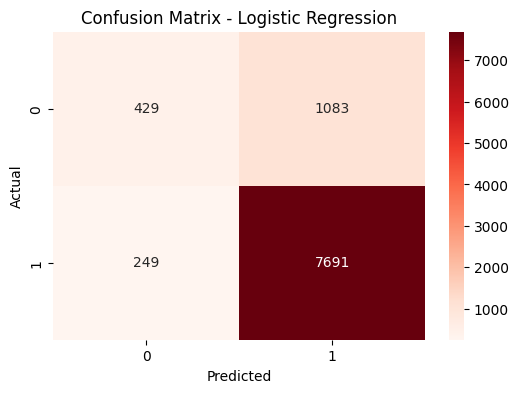

In [ ]:
# Assuming you have a training set called X_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)  # Transform the test set

# Initialize Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=20000)

# Cross-validation
cv_scores = cross_val_score(logistic_model, X_train_vectorized, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model
logistic_model.fit(X_train_vectorized, y_train)

# Evaluate on training and test sets
train_score = logistic_model.score(X_train_vectorized, y_train)
test_score = logistic_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Make predictions
y_train_pred = logistic_model.predict(X_train_vectorized)
y_test_pred = logistic_model.predict(X_test_vectorized)

# Classification reports
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Logistic Regression', fontsize=12)
plt.show()

##SUPPORT VECTOR MACHINE

Cross-validation scores: [0.85030415 0.85083311 0.85187145 0.85372305 0.85597143]
Mean cross-validation accuracy: 0.8525 (+/- 0.0042)
Training Accuracy: 0.8533
Testing Accuracy: 0.8584

Training Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.16      0.26      6284
           1       0.85      0.99      0.92     31523

    accuracy                           0.85     37807
   macro avg       0.83      0.57      0.59     37807
weighted avg       0.85      0.85      0.81     37807


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.15      0.26      1512
           1       0.86      0.99      0.92      7940

    accuracy                           0.86      9452
   macro avg       0.83      0.57      0.59      9452
weighted avg       0.85      0.86      0.82      9452



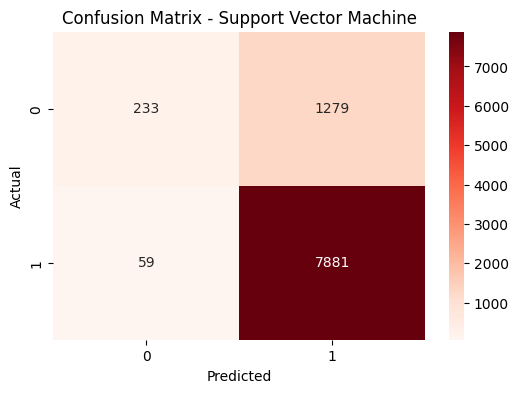

In [ ]:
# Assuming you have a training set called X_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)  # Transform the test set

# Initialize Support Vector Machine model
svm_model = SVC(kernel='linear', random_state=42)

# Cross-validation
cv_scores = cross_val_score(svm_model, X_train_vectorized, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model
svm_model.fit(X_train_vectorized, y_train)

# Evaluate on training and test sets
train_score = svm_model.score(X_train_vectorized, y_train)
test_score = svm_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Make predictions
y_train_pred = svm_model.predict(X_train_vectorized)
y_test_pred = svm_model.predict(X_test_vectorized)

# Classification reports
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Support Vector Machine', fontsize=12)
plt.show()


##RANDOM FOREST

Cross-validation scores: [0.84369214 0.84210526 0.84525856 0.85094564 0.83996826]
Mean cross-validation accuracy: 0.8444 (+/- 0.0074)
Training Accuracy: 0.9711
Testing Accuracy: 0.8460

Training Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      6284
           1       0.98      0.99      0.98     31523

    accuracy                           0.97     37807
   macro avg       0.96      0.93      0.95     37807
weighted avg       0.97      0.97      0.97     37807


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.29      0.38      1512
           1       0.88      0.95      0.91      7940

    accuracy                           0.85      9452
   macro avg       0.70      0.62      0.65      9452
weighted avg       0.82      0.85      0.83      9452



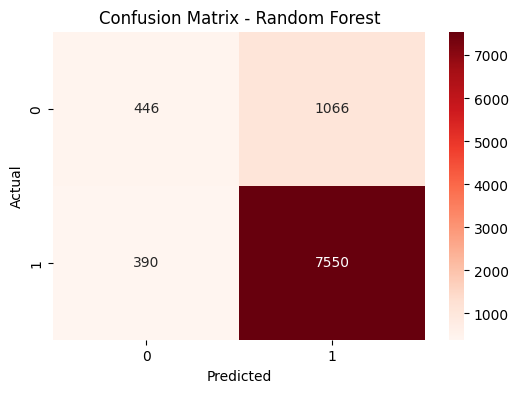

In [ ]:
# Assuming you have a training set called X_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Cross-validation
cv_scores = cross_val_score(rf_model, X_train_vectorized, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model
rf_model.fit(X_train_vectorized, y_train)

# Evaluate on training and test sets
train_score = rf_model.score(X_train_vectorized, y_train)
test_score = rf_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Make predictions
y_train_pred = rf_model.predict(X_train_vectorized)
y_test_pred = rf_model.predict(X_test_vectorized)

# Classification reports
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Random Forest', fontsize=12)
plt.show()


# GloVe 50D

In [ ]:
def load_glove_embeddings(file_path, embedding_dim):
    print(f"Loading GloVe embeddings ({embedding_dim}d)...")
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

    from sklearn.base import BaseEstimator, TransformerMixin

# Load the embeddings (choose one of these)
glove_50d = load_glove_embeddings('glove.twitter.27B.50d.txt', 50)
#glove_100d = load_glove_embeddings('glove.twitter.27B.100d.txt', 100)
#glove_200d = load_glove_embeddings('glove.twitter.27B.200d.txt', 200)

glove_file = '/content/glove.twitter.27B.50d.txt'
embedding_dim = 50
glove_dict = load_glove_embeddings(glove_file, embedding_dim)

class GloVeVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, glove_dict, embedding_dim):
        self.glove_dict = glove_dict
        self.embedding_dim = embedding_dim

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.glove_dict.get(word, np.zeros(self.embedding_dim))
                     for word in text.split()
                     if word in self.glove_dict]
                    or [np.zeros(self.embedding_dim)], axis=0)
            for text in X
        ])

Loading GloVe embeddings (50d)...


Loading GloVe: 1193514it [00:26, 44636.24it/s]


Loading GloVe embeddings (50d)...


Loading GloVe: 1193514it [00:32, 36890.52it/s]


Cross-validation scores: [0.84924623 0.85096535 0.85755852 0.85941013 0.85464886]
Mean cross-validation accuracy: 0.8544 (+/- 0.0077)
Training Accuracy: 0.8547
Testing Accuracy: 0.8542

Training Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.27      0.38      6284
           1       0.87      0.97      0.92     31523

    accuracy                           0.85     37807
   macro avg       0.76      0.62      0.65     37807
weighted avg       0.83      0.85      0.83     37807


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.25      0.35      1512
           1       0.87      0.97      0.92      7940

    accuracy                           0.85      9452
   macro avg       0.74      0.61      0.64      9452
weighted avg       0.83      0.85      0.83      9452



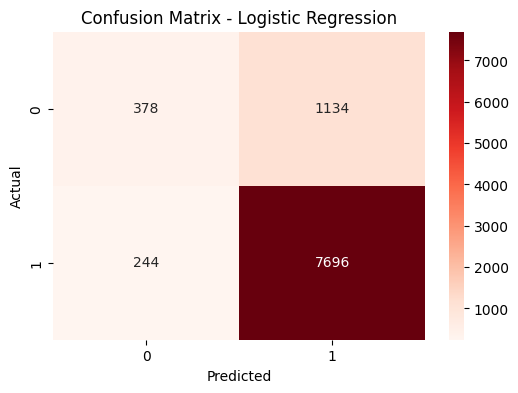

In [ ]:
# Assuming you have a training set called X_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)  # Transform the test set

# Initialize Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=20000)

# Cross-validation
cv_scores = cross_val_score(logistic_model, X_train_vectorized, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model
logistic_model.fit(X_train_vectorized, y_train)

# Evaluate on training and test sets
train_score = logistic_model.score(X_train_vectorized, y_train)
test_score = logistic_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Make predictions
y_train_pred = logistic_model.predict(X_train_vectorized)
y_test_pred = logistic_model.predict(X_test_vectorized)

# Classification reports
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Logistic Regression', fontsize=12)
plt.show()

Cross-validation scores: [0.84686591 0.84303094 0.84406824 0.8442005  0.84658114]
Mean cross-validation accuracy: 0.8449 (+/- 0.0030)
Training Accuracy: 0.8448
Testing Accuracy: 0.8499

Training Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.07      0.14      6284
           1       0.84      1.00      0.91     31523

    accuracy                           0.84     37807
   macro avg       0.88      0.54      0.53     37807
weighted avg       0.86      0.84      0.79     37807


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.07      0.14      1512
           1       0.85      1.00      0.92      7940

    accuracy                           0.85      9452
   macro avg       0.85      0.54      0.53      9452
weighted avg       0.85      0.85      0.79      9452



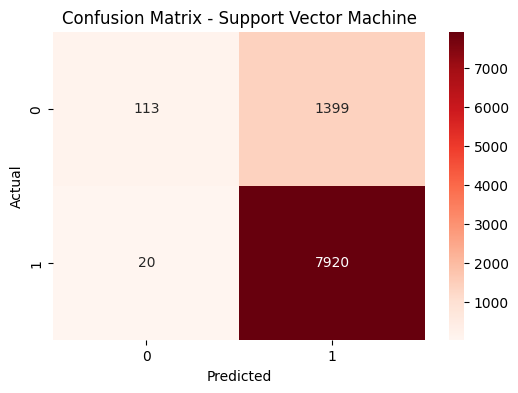

In [ ]:
# Assuming you have a training set called X_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)  # Transform the test set

# Initialize Support Vector Machine model
svm_model = SVC(kernel='linear', random_state=42)

# Cross-validation
cv_scores = cross_val_score(svm_model, X_train_vectorized, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model
svm_model.fit(X_train_vectorized, y_train)

# Evaluate on training and test sets
train_score = svm_model.score(X_train_vectorized, y_train)
test_score = svm_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Make predictions
y_train_pred = svm_model.predict(X_train_vectorized)
y_test_pred = svm_model.predict(X_test_vectorized)

# Classification reports
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Support Vector Machine', fontsize=12)
plt.show()


Cross-validation scores: [0.84435335 0.84170854 0.84605211 0.84790372 0.84023277]
Mean cross-validation accuracy: 0.8441 (+/- 0.0056)
Training Accuracy: 0.9710
Testing Accuracy: 0.8447

Training Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      6284
           1       0.98      0.99      0.98     31523

    accuracy                           0.97     37807
   macro avg       0.96      0.93      0.95     37807
weighted avg       0.97      0.97      0.97     37807


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.30      0.38      1512
           1       0.88      0.95      0.91      7940

    accuracy                           0.84      9452
   macro avg       0.70      0.63      0.65      9452
weighted avg       0.82      0.84      0.83      9452



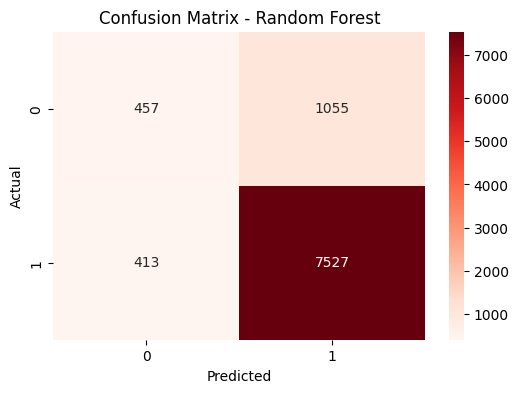

In [ ]:
# Assuming you have a training set called X_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Cross-validation
cv_scores = cross_val_score(rf_model, X_train_vectorized, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model
rf_model.fit(X_train_vectorized, y_train)

# Evaluate on training and test sets
train_score = rf_model.score(X_train_vectorized, y_train)
test_score = rf_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Make predictions
y_train_pred = rf_model.predict(X_train_vectorized)
y_test_pred = rf_model.predict(X_test_vectorized)

# Classification reports
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Random Forest', fontsize=12)
plt.show()


# GloVe 200D

In [ ]:
def load_glove_embeddings(file_path, embedding_dim):
    print(f"Loading GloVe embeddings ({embedding_dim}d)...")
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

    from sklearn.base import BaseEstimator, TransformerMixin

# Load the embeddings (choose one of these)
#glove_50d = load_glove_embeddings('glove.twitter.27B.50d.txt', 50)
#glove_100d = load_glove_embeddings('glove.twitter.27B.100d.txt', 100)
glove_200d = load_glove_embeddings('glove.twitter.27B.200d.txt', 200)

glove_file = '/content/glove.twitter.27B.200d.txt'
embedding_dim = 200
glove_dict = load_glove_embeddings(glove_file, embedding_dim)

class GloVeVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, glove_dict, embedding_dim):
        self.glove_dict = glove_dict
        self.embedding_dim = embedding_dim

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.glove_dict.get(word, np.zeros(self.embedding_dim))
                     for word in text.split()
                     if word in self.glove_dict]
                    or [np.zeros(self.embedding_dim)], axis=0)
            for text in X
        ])

Loading GloVe embeddings (200d)...


Loading GloVe: 1193514it [01:28, 13503.55it/s]


Loading GloVe embeddings (200d)...


Loading GloVe: 1193514it [01:42, 11594.30it/s]


Logistic Regression

Cross-validation scores: [0.85122983 0.86154456 0.86073271 0.86496495 0.85954239]
Mean cross-validation accuracy: 0.8596 (+/- 0.0091)
Training Accuracy: 0.8633
Testing Accuracy: 0.8627

Training Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.32      0.44      6284
           1       0.88      0.97      0.92     31523

    accuracy                           0.86     37807
   macro avg       0.78      0.65      0.68     37807
weighted avg       0.85      0.86      0.84     37807


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.31      0.42      1512
           1       0.88      0.97      0.92      7940

    accuracy                           0.86      9452
   macro avg       0.76      0.64      0.67      9452
weighted avg       0.84      0.86      0.84      9452



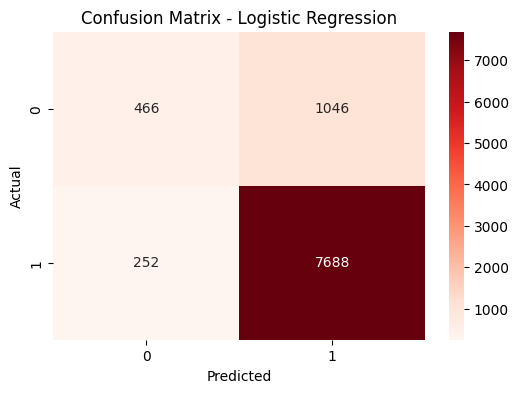

In [ ]:
# Assuming you have a training set called X_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)  # Transform the test set

# Initialize Logistic Regression model
logistic_model = LogisticRegression(random_state=42, max_iter=20000)

# Cross-validation
cv_scores = cross_val_score(logistic_model, X_train_vectorized, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model
logistic_model.fit(X_train_vectorized, y_train)

# Evaluate on training and test sets
train_score = logistic_model.score(X_train_vectorized, y_train)
test_score = logistic_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Make predictions
y_train_pred = logistic_model.predict(X_train_vectorized)
y_test_pred = logistic_model.predict(X_test_vectorized)

# Classification reports
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Logistic Regression', fontsize=12)
plt.show()

Support Vector Machine

Cross-validation scores: [0.85493256 0.85942872 0.85914562 0.8623198  0.86033593]
Mean cross-validation accuracy: 0.8592 (+/- 0.0048)
Training Accuracy: 0.8607
Testing Accuracy: 0.8639

Training Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.23      0.35      6284
           1       0.86      0.99      0.92     31523

    accuracy                           0.86     37807
   macro avg       0.82      0.61      0.64     37807
weighted avg       0.85      0.86      0.83     37807


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.23      0.35      1512
           1       0.87      0.98      0.92      7940

    accuracy                           0.86      9452
   macro avg       0.81      0.61      0.64      9452
weighted avg       0.85      0.86      0.83      9452



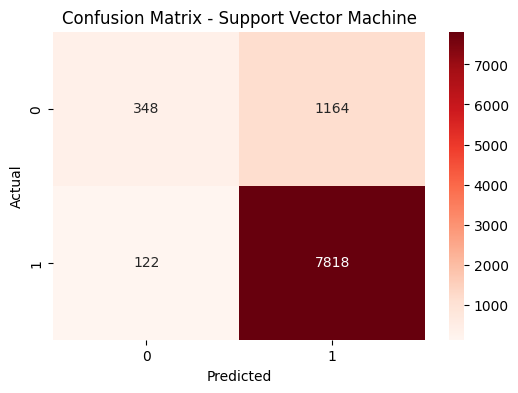

In [ ]:
# Assuming you have a training set called X_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)  # Transform the test set

# Initialize Support Vector Machine model
svm_model = SVC(kernel='linear', random_state=42)

# Cross-validation
cv_scores = cross_val_score(svm_model, X_train_vectorized, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model
svm_model.fit(X_train_vectorized, y_train)

# Evaluate on training and test sets
train_score = svm_model.score(X_train_vectorized, y_train)
test_score = svm_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Make predictions
y_train_pred = svm_model.predict(X_train_vectorized)
y_test_pred = svm_model.predict(X_test_vectorized)

# Classification reports
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Support Vector Machine', fontsize=12)
plt.show()


Cross-validation scores: [0.84303094 0.84501455 0.84512631 0.84816823 0.83904245]
Mean cross-validation accuracy: 0.8441 (+/- 0.0060)
Training Accuracy: 0.9711
Testing Accuracy: 0.8418

Training Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      6284
           1       0.98      0.99      0.98     31523

    accuracy                           0.97     37807
   macro avg       0.96      0.93      0.95     37807
weighted avg       0.97      0.97      0.97     37807


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.29      0.37      1512
           1       0.88      0.95      0.91      7940

    accuracy                           0.84      9452
   macro avg       0.69      0.62      0.64      9452
weighted avg       0.82      0.84      0.82      9452



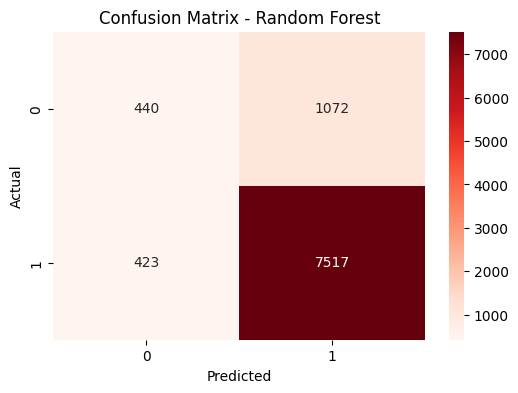

In [ ]:
# Assuming you have a training set called X_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Cross-validation
cv_scores = cross_val_score(rf_model, X_train_vectorized, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model
rf_model.fit(X_train_vectorized, y_train)

# Evaluate on training and test sets
train_score = rf_model.score(X_train_vectorized, y_train)
test_score = rf_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Make predictions
y_train_pred = rf_model.predict(X_train_vectorized)
y_test_pred = rf_model.predict(X_test_vectorized)

# Classification reports
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Random Forest', fontsize=12)
plt.show()

# SMOTE ON GLOVE 100D

In [ ]:
from imblearn.over_sampling import SMOTE



## LOGISTIC REGRESSION

Loading GloVe embeddings (100d)...


Loading GloVe: 1193514it [00:52, 22684.73it/s]


Loading GloVe embeddings (100d)...


Loading GloVe: 1193514it [01:07, 17662.96it/s]



Logistic Regression Results:
Cross-validation scores: [0.75590801 0.77365374 0.77198826 0.77872948 0.77095725]
Mean cross-validation accuracy: 0.7702 (+/- 0.0153)
Training Accuracy: 0.7719
Testing Accuracy: 0.7660

Training Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77     31523
           1       0.77      0.77      0.77     31523

    accuracy                           0.77     63046
   macro avg       0.77      0.77      0.77     63046
weighted avg       0.77      0.77      0.77     63046


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.74      0.50      1512
           1       0.94      0.77      0.85      7940

    accuracy                           0.77      9452
   macro avg       0.66      0.75      0.67      9452
weighted avg       0.85      0.77      0.79      9452



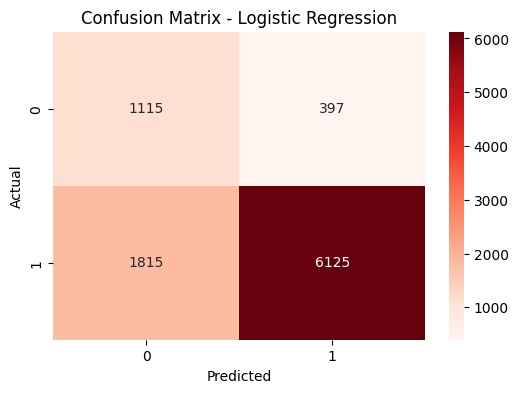

In [ ]:
def load_glove_embeddings(file_path, embedding_dim):
    print(f"Loading GloVe embeddings ({embedding_dim}d)...")
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

    from sklearn.base import BaseEstimator, TransformerMixin

# Load the embeddings (choose one of these)
#glove_50d = load_glove_embeddings('glove.twitter.27B.50d.txt', 50)
glove_100d = load_glove_embeddings('glove.twitter.27B.100d.txt', 100)
#glove_200d = load_glove_embeddings('glove.twitter.27B.200d.txt', 200)

glove_file = '/content/glove.twitter.27B.100d.txt'
embedding_dim = 100
glove_dict = load_glove_embeddings(glove_file, embedding_dim)

class GloVeVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, glove_dict, embedding_dim):
        self.glove_dict = glove_dict
        self.embedding_dim = embedding_dim

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.glove_dict.get(word, np.zeros(self.embedding_dim))
                     for word in text.split()
                     if word in self.glove_dict]
                    or [np.zeros(self.embedding_dim)], axis=0)
            for text in X
        ])

# Assuming you have a training set called X_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)  # Transform the test set

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

# Logistic Regression
print("\nLogistic Regression Results:")
lr_model = LogisticRegression(random_state=42, max_iter=20000)

# Cross-validation
cv_scores = cross_val_score(lr_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model
lr_model.fit(X_train_resampled, y_train_resampled)

# Evaluate on training and test sets
train_score = lr_model.score(X_train_resampled, y_train_resampled)
test_score = lr_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Classification reports
y_train_pred = lr_model.predict(X_train_resampled)
y_test_pred = lr_model.predict(X_test_vectorized)

print("\nTraining Classification Report:")
print(classification_report(y_train_resampled, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Logistic Regression', fontsize=12)
plt.show()

## SUPPORT VECTOR MACHINE

Loading GloVe embeddings (100d)...


Loading GloVe: 1193514it [01:41, 11738.12it/s]



Support Vector Machine Results:
Cross-validation scores: [0.76145916 0.78087081 0.77920533 0.78277421 0.77642953]
Mean cross-validation accuracy: 0.7761 (+/- 0.0153)
Training Accuracy (on resampled data): 0.7780
Testing Accuracy: 0.7610

Training Classification Report (on resampled data):
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     31523
           1       0.79      0.76      0.77     31523

    accuracy                           0.78     63046
   macro avg       0.78      0.78      0.78     63046
weighted avg       0.78      0.78      0.78     63046


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.75      0.50      1512
           1       0.94      0.76      0.84      7940

    accuracy                           0.76      9452
   macro avg       0.66      0.76      0.67      9452
weighted avg       0.85      0.76      0.79      9452



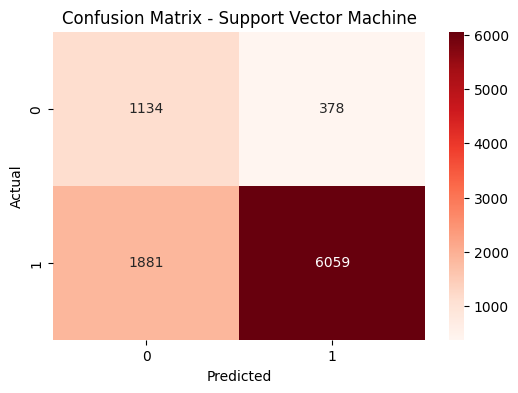

In [ ]:
def load_glove_embeddings(file_path, embedding_dim):
    print(f"Loading GloVe embeddings ({embedding_dim}d)...")
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

glove_file = '/content/glove.twitter.27B.100d.txt'
embedding_dim = 100
glove_dict = load_glove_embeddings(glove_file, embedding_dim)

class GloVeVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, glove_dict, embedding_dim):
        self.glove_dict = glove_dict
        self.embedding_dim = embedding_dim

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.glove_dict.get(word, np.zeros(self.embedding_dim))
                     for word in text.split()
                     if word in self.glove_dict]
                    or [np.zeros(self.embedding_dim)], axis=0)
            for text in X
        ])

# Assuming you have a training set called X_train and y_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)  # Transform the test set

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

# Initialize Support Vector Machine model
print("\nSupport Vector Machine Results:")
svm_model = SVC(kernel='linear', random_state=42)

# Cross-validation on resampled data
cv_scores = cross_val_score(svm_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model on resampled data
svm_model.fit(X_train_resampled, y_train_resampled)

# Evaluate on resampled training and original test sets
train_score = svm_model.score(X_train_resampled, y_train_resampled)
test_score = svm_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy (on resampled data): {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Make predictions
y_train_pred = svm_model.predict(X_train_resampled)
y_test_pred = svm_model.predict(X_test_vectorized)

# Classification reports
print("\nTraining Classification Report (on resampled data):")
print(classification_report(y_train_resampled, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Support Vector Machine', fontsize=12)
plt.show()

Loading GloVe embeddings (100d)...


Loading GloVe: 1193514it [01:14, 15931.20it/s]



Random Forest Results:
Cross-validation scores: [0.84044409 0.892775   0.89221984 0.8937267  0.88658894]
Mean cross-validation accuracy: 0.8812 (+/- 0.0410)
Training Accuracy (on resampled data): 0.9806
Testing Accuracy: 0.8107

Training Classification Report (on resampled data):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     31523
           1       0.99      0.97      0.98     31523

    accuracy                           0.98     63046
   macro avg       0.98      0.98      0.98     63046
weighted avg       0.98      0.98      0.98     63046


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.55      0.48      1512
           1       0.91      0.86      0.88      7940

    accuracy                           0.81      9452
   macro avg       0.67      0.71      0.68      9452
weighted avg       0.83      0.81      0.82      9452



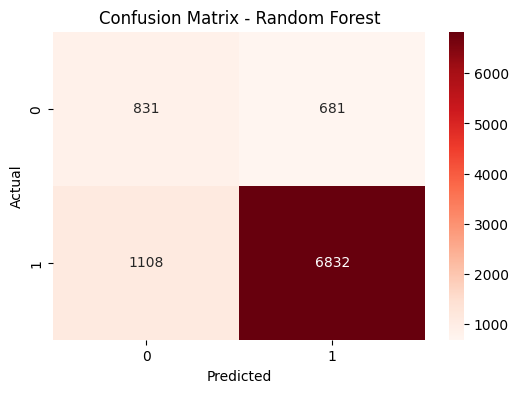

In [ ]:
def load_glove_embeddings(file_path, embedding_dim):
    print(f"Loading GloVe embeddings ({embedding_dim}d)...")
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict
glove_file = '/content/glove.twitter.27B.100d.txt'
embedding_dim = 100
glove_dict = load_glove_embeddings(glove_file, embedding_dim)

class GloVeVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, glove_dict, embedding_dim):
        self.glove_dict = glove_dict
        self.embedding_dim = embedding_dim

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.glove_dict.get(word, np.zeros(self.embedding_dim))
                     for word in text.split()
                     if word in self.glove_dict]
                    or [np.zeros(self.embedding_dim)], axis=0)
            for text in X
        ])

# Assuming you have a training set called X_train and y_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)  # Transform the test set

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

# Initialize Random Forest model
print("\nRandom Forest Results:")
rf_model = RandomForestClassifier(random_state=42)

# Cross-validation on resampled data
cv_scores = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model on resampled data
rf_model.fit(X_train_resampled, y_train_resampled)

# Evaluate on resampled training and original test sets
train_score = rf_model.score(X_train_resampled, y_train_resampled)
test_score = rf_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy (on resampled data): {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Make predictions
y_train_pred = rf_model.predict(X_train_resampled)
y_test_pred = rf_model.predict(X_test_vectorized)

# Classification reports
print("\nTraining Classification Report (on resampled data):")
print(classification_report(y_train_resampled, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Random Forest', fontsize=12)
plt.show()


# **HYPERPARAMETER TUNING USING GRIDSEARCH**

## LINEAR REGRESSION

Loading GloVe embeddings (100d)...


Loading GloVe: 1193514it [00:57, 20796.07it/s]


Cross-validation scores: [0.85175879 0.85863528 0.85848433 0.86126174 0.85742627]
Mean cross-validation accuracy: 0.8575 (+/- 0.0063)
Training Accuracy: 0.8575
Testing Accuracy: 0.8592

Training Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.30      0.41      6284
           1       0.87      0.97      0.92     31523

    accuracy                           0.86     37807
   macro avg       0.77      0.63      0.67     37807
weighted avg       0.84      0.86      0.83     37807


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.28      0.39      1512
           1       0.88      0.97      0.92      7940

    accuracy                           0.86      9452
   macro avg       0.76      0.63      0.66      9452
weighted avg       0.84      0.86      0.84      9452



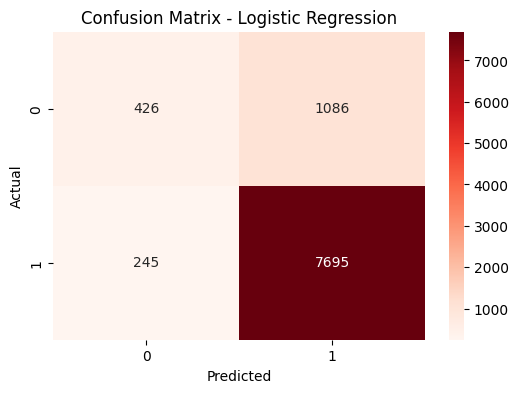

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

def load_glove_embeddings(file_path, embedding_dim):
    print(f"Loading GloVe embeddings ({embedding_dim}d)...")
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

glove_file = '/content/glove.twitter.27B.100d.txt'
embedding_dim = 100
glove_dict = load_glove_embeddings(glove_file, embedding_dim)

class GloVeVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, glove_dict, embedding_dim):
        self.glove_dict = glove_dict
        self.embedding_dim = embedding_dim

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.glove_dict.get(word, np.zeros(self.embedding_dim))
                     for word in text.split()
                     if word in self.glove_dict]
                    or [np.zeros(self.embedding_dim)], axis=0)
            for text in X
        ])

# Assuming you have a training set called X_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)  # Transform the test set

# Initialize Logistic Regression model
logistic_model = LogisticRegression(random_state=42, C=1, penalty='l1', solver='saga', max_iter=20000)

# Cross-validation
cv_scores = cross_val_score(logistic_model, X_train_vectorized, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model
logistic_model.fit(X_train_vectorized, y_train)

# Evaluate on training and test sets
train_score = logistic_model.score(X_train_vectorized, y_train)
test_score = logistic_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Make predictions
y_train_pred = logistic_model.predict(X_train_vectorized)
y_test_pred = logistic_model.predict(X_test_vectorized)

# Classification reports
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Logistic Regression', fontsize=12)
plt.show()

## SUPPORT VECTOR MACHINE

Loading GloVe embeddings (100d)...


Loading GloVe: 1193514it [01:32, 12913.26it/s]


Cross-validation scores: [0.84832055 0.84633695 0.84869726 0.85147467 0.85121016]
Mean cross-validation accuracy: 0.8492 (+/- 0.0038)
Training Accuracy: 0.8507
Testing Accuracy: 0.8573

Training Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.14      0.24      6284
           1       0.85      0.99      0.92     31523

    accuracy                           0.85     37807
   macro avg       0.82      0.57      0.58     37807
weighted avg       0.84      0.85      0.80     37807


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.15      0.25      1512
           1       0.86      0.99      0.92      7940

    accuracy                           0.86      9452
   macro avg       0.83      0.57      0.58      9452
weighted avg       0.85      0.86      0.81      9452



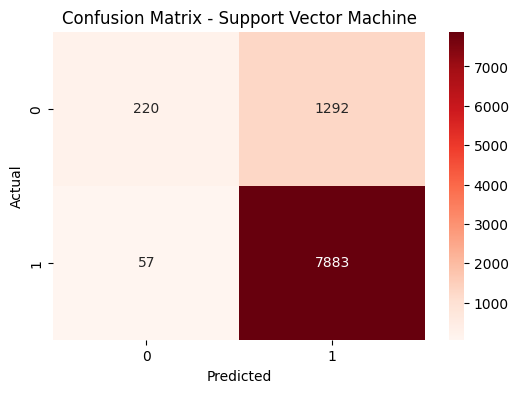

In [ ]:
def load_glove_embeddings(file_path, embedding_dim):
    print(f"Loading GloVe embeddings ({embedding_dim}d)...")
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

glove_file = '/content/glove.twitter.27B.100d.txt'
embedding_dim = 100
glove_dict = load_glove_embeddings(glove_file, embedding_dim)

class GloVeVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, glove_dict, embedding_dim):
        self.glove_dict = glove_dict
        self.embedding_dim = embedding_dim

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.glove_dict.get(word, np.zeros(self.embedding_dim))
                     for word in text.split()
                     if word in self.glove_dict]
                    or [np.zeros(self.embedding_dim)], axis=0)
            for text in X
        ])

# Assuming you have a training set called X_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)  # Transform the test set

# Initialize Support Vector Machine model
svm_model = SVC(kernel='sigmoid', C=1, gamma='auto', random_state=42)

# Cross-validation
cv_scores = cross_val_score(svm_model, X_train_vectorized, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model
svm_model.fit(X_train_vectorized, y_train)

# Evaluate on training and test sets
train_score = svm_model.score(X_train_vectorized, y_train)
test_score = svm_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Make predictions
y_train_pred = svm_model.predict(X_train_vectorized)
y_test_pred = svm_model.predict(X_test_vectorized)

# Classification reports
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Support Vector Machine', fontsize=12)
plt.show()

## RANDOM FOREST

Loading GloVe embeddings (100d)...


Loading GloVe: 1193514it [01:41, 11771.77it/s]


Cross-validation scores: [0.84475007 0.8428987  0.84750694 0.84830049 0.84314244]
Mean cross-validation accuracy: 0.8453 (+/- 0.0044)
Training Accuracy: 0.9682
Testing Accuracy: 0.8449

Training Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      6284
           1       0.97      0.99      0.98     31523

    accuracy                           0.97     37807
   macro avg       0.96      0.92      0.94     37807
weighted avg       0.97      0.97      0.97     37807


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.28      0.37      1512
           1       0.87      0.95      0.91      7940

    accuracy                           0.84      9452
   macro avg       0.70      0.62      0.64      9452
weighted avg       0.82      0.84      0.82      9452



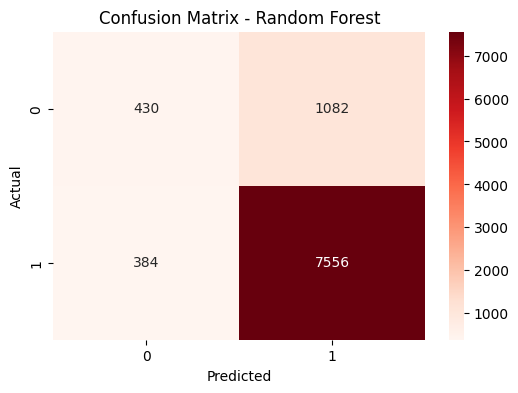

In [ ]:
def load_glove_embeddings(file_path, embedding_dim):
    print(f"Loading GloVe embeddings ({embedding_dim}d)...")
    embeddings_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

glove_file = '/content/glove.twitter.27B.100d.txt'
embedding_dim = 100
glove_dict = load_glove_embeddings(glove_file, embedding_dim)

class GloVeVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, glove_dict, embedding_dim):
        self.glove_dict = glove_dict
        self.embedding_dim = embedding_dim

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.glove_dict.get(word, np.zeros(self.embedding_dim))
                     for word in text.split()
                     if word in self.glove_dict]
                    or [np.zeros(self.embedding_dim)], axis=0)
            for text in X
        ])

# Assuming you have a training set called X_train...
vectorizer = GloVeVectorizer(glove_dict, embedding_dim)  # Create a GloVeVectorizer instance
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42)

# Cross-validation
cv_scores = cross_val_score(rf_model, X_train_vectorized, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the model
rf_model.fit(X_train_vectorized, y_train)

# Evaluate on training and test sets
train_score = rf_model.score(X_train_vectorized, y_train)
test_score = rf_model.score(X_test_vectorized, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy: {test_score:.4f}")

# Make predictions
y_train_pred = rf_model.predict(X_train_vectorized)
y_test_pred = rf_model.predict(X_test_vectorized)

# Classification reports
print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', annot_kws={"fontsize":10})
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix - Random Forest', fontsize=12)
plt.show()